### Overview
This notebook reads a pre-processed set of **English questions** from Kenyan farmers, selects questions on **tomato**;   
tokenizes words, removes stopwords, & lemmatizes verbs; creates bi-and tri-grams and network visualizations


### Inputs: (files saved to your working directory)
* CSV files of cleaned / lower case /  punctuation removed questions: 'kenya_eng_q_clean.csv' 
* created by *question_preprocess.ipynb* --> *kenya-q_eng.ipynb* notebook code

### Output files (in working directory)
* CSV file of top 500 bigrams: 'ken_eng_bigrams_top500_tomato.csv'
* CSV file of top 500 trigrams:  'ken_eng_trigrams_top500_tomato.csv'
* HTML file of interactive network diagram of top 40 bigrams: '40bigram_eng_ken_tomato_network.html'                                     
* HTML file of interactive network diagram of top 40 trigrams: '40trigram_eng_ken_tomato_network.html'

                                          
### Steps:
1. Select questions topic == 'tomato'
2. Tokenize - takes ~ 3-4 min to run
3. Remove stopwords & lemmatise verbs
4. Create english bigrams, trigrams, & quadgrams; save as csv files
5. Plot frequency distribution of top 20 bigrams, trigrams
6. Plot & save interactive network graphs of top 40 bigrams and trigrams
7. Save top 500 bi- and tri- grams in CSV files
                                                                                                                                                                       
### Local Variables (partial list):
* q_df       
* ken_q_list
* ken_eng_tokens
* all_bigrams
* all_trigrams
* bigram_freq
* unigram_freq                                          
* trigram_freq
                                                                                                                                

In [2]:
#import packages:  pandas, numpy,nltk, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import string
import re

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

#first - pyvis install in conda prompt: 'conda install conda-forge::pyvis'
from pyvis.network import Network

from collections import Counter

from IPython.display import HTML, display, IFrame


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
#load processed country question file
q_df = pd.read_csv('kenya_eng_q_clean.csv')
q_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384774 entries, 0 to 1384773
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Unnamed: 0      1384774 non-null  int64 
 1   question_id     1384774 non-null  int64 
 2   question_topic  1083079 non-null  object
 3   question_clean  1384774 non-null  object
dtypes: int64(2), object(2)
memory usage: 42.3+ MB


In [4]:
#select questions with topic = 'tomato':

eng_kenya_df=q_df.loc[(q_df['question_topic'] == 'tomato'),['question_id', 'question_topic', 'question_clean']]
len(eng_kenya_df)
#eng_kenya_df = clean_df.loc[(clean_df['question_topic'] != ''),['question_clean']]
eng_kenya_df.head()


,question_id,question_topic,question_clean
8,3850312,tomato,is good to feed dairy cattle with stale paw ...
21,3850739,tomato,one green house can give me how many kilos of ...
24,3850759,tomato,what are the best tomatoes variety
39,3851790,tomato,how is tomatoes planted
42,3851859,tomato,what the best fertilizer to use before and aft...


In [5]:
print("the number of english tomato questions: ", len(eng_kenya_df))

the number of english tomato questions:  60163


In [6]:
#create list of questions to be tokenized:
ken_q_list=list(eng_kenya_df['question_clean'])
print(ken_q_list[0:5])


['  is good to feed dairy cattle with stale paw paws ovacados and tomatoes', 'one green house can give me how many kilos of tomatos', 'what are the best tomatoes variety   ', 'how is tomatoes planted', 'what the best fertilizer to use before and after planting tomatoes']


In [7]:
# Define functions to tokenize list of questions:  


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def normalize_verbs(token_list):
    """Lemmatize verbs only."""
    return [lemmatizer.lemmatize(tok, wordnet.VERB) for tok in token_list]

def tokenize_stopwords_normalize(str_list):
    processed = []

    for text in str_list:
        # 1️⃣ tokenize
        tokens = word_tokenize(text)

        # 2️⃣ remove stopwords
        tokens = [
            t for t in tokens
            if t not in stop_words 
        ]

        # 3️⃣ normalize verbs
        tokens = normalize_verbs(tokens)

        processed.append(tokens)

    return processed

In [8]:
ken_eng_tokens = tokenize_stopwords_normalize(ken_q_list)
print(ken_eng_tokens[0:5])
print("Number of tokens: ", len(ken_eng_tokens))

[['good', 'fee', 'dairy', 'cattle', 'stale', 'paw', 'paw', 'ovacados', 'tomatoes'], ['one', 'green', 'house', 'give', 'many', 'kilos', 'tomatos'], ['best', 'tomatoes', 'variety'], ['tomatoes', 'plant'], ['best', 'fertilizer', 'use', 'plant', 'tomatoes']]
Number of tokens:  60163


In [9]:
#create list of bigrams:
all_bigrams = []

for question in ken_eng_tokens:
    #create bigrams iterator for each element of tokens: ken_eng_tokens.csv
    bigram_iterator = bigrams(question)
    bigram_list = list(bigram_iterator)

    # Add the bigrams of the current question to the overall list
    all_bigrams.extend(bigram_list)

In [10]:
#create list of trigrams, if # tokens >= 3
all_trigrams = []

for question in ken_eng_tokens:
    if len(question) < 3:
        continue
            #create bigrams iterator for each element of tokens: 
    else:
        all_trigrams.extend(list(trigrams(question)))


In [11]:
print("# of trigrams: ", len(all_trigrams))
print(all_trigrams[0:5])
type(all_trigrams)

# of trigrams:  236317
[('good', 'fee', 'dairy'), ('fee', 'dairy', 'cattle'), ('dairy', 'cattle', 'stale'), ('cattle', 'stale', 'paw'), ('stale', 'paw', 'paw')]


list

In [12]:
print("# of bigrams: ", len(all_bigrams))
print(all_bigrams[0:5])
type(all_bigrams)

# of bigrams:  296420
[('good', 'fee'), ('fee', 'dairy'), ('dairy', 'cattle'), ('cattle', 'stale'), ('stale', 'paw')]


list

In [13]:
bigram_freq = Counter(all_bigrams)
#type(bigram_freq)

In [14]:
trigram_freq = Counter(all_trigrams)
#type(trigram_freq)

### Bigram Visualizations:  Note - drop "reply, follow" and "follow, response"  bigrams (index = 5,6)

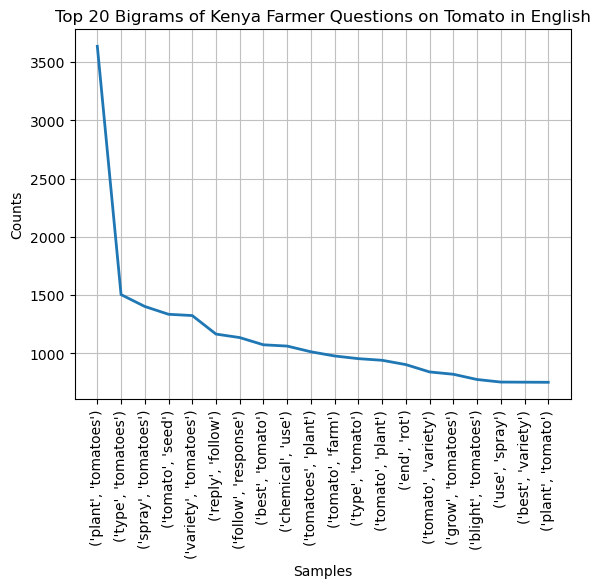

In [15]:
#plot frequency distribution of bigrams
fdist = FreqDist(all_bigrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} Bigrams of Kenya Farmer Questions on Tomato in English")
#plt.text(0.5, 1.02, "Source:  WeFarm SMS platform messages among farmers in East Africa, 2022" , fontsize=10, ha='center')
plt.savefig("top20bigrams_tomato_ken_eng.png")

In [16]:
#unigram counts for node-size based on token frequency:
 
unigram_freq = Counter(tok for tokens in ken_eng_tokens for tok in tokens)
print(unigram_freq.most_common(75))

[('tomatoes', 37543), ('tomato', 16744), ('best', 10934), ('plant', 9688), ('use', 6208), ('type', 4513), ('control', 4354), ('variety', 3839), ('seed', 3780), ('tomatoe', 3224), ('spray', 3098), ('farm', 2937), ('grow', 2803), ('season', 2670), ('chemical', 2664), ('good', 2636), ('ask', 2405), ('fruit', 2386), ('many', 2222), ('cause', 2221), ('flower', 2202), ('take', 2159), ('blight', 2135), ('one', 2093), ('tomatos', 2057), ('get', 1978), ('long', 1845), ('well', 1828), ('wilt', 1730), ('transplant', 1724), ('start', 1692), ('time', 1649), ('county', 1639), ('rot', 1636), ('leave', 1524), ('market', 1502), ('harvest', 1488), ('want', 1474), ('prevent', 1421), ('dry', 1389), ('follow', 1353), ('apply', 1339), ('black', 1338), ('stage', 1323), ('rain', 1315), ('much', 1300), ('need', 1294), ('reply', 1285), ('affect', 1278), ('f', 1261), ('fertilizer', 1210), ('response', 1151), ('end', 1118), ('space', 1072), ('disease', 1061), ('seedlings', 1053), ('chemicals', 1043), ('make', 100

In [36]:
#create interactive directed network chart...with help from Anaconda toolbox

# Variables:
# - bigram_freq: Counter object with bigram frequencies (ranging from ~400 to 3600)
# - unigram_freq: Counter object with country unigram frequencies (up to ~ 38000)

# Get top 40 bigrams, excluding the 6th and 7th:  
top_n = 40
top_bigrams = bigram_freq.most_common(top_n+2) 
del top_bigrams[5:7]

 
# Create a graph
G = nx.DiGraph()

# Add edges (bigrams) with weights based on frequency
for bigram, frequency in top_bigrams:
    word1, word2 = bigram
    G.add_edge(word1, word2, value=frequency, title=f"Frequency: {frequency}")

# Calculate node sizes based on unigram frequencies
max_node_size = 50  # Maximum node size for visualization
min_node_size = 10  # Minimum node size for visualization

# Get all unique words from the bigrams
all_words = set()
for bigram, _ in top_bigrams:
    all_words.add(bigram[0])
    all_words.add(bigram[1])

# Set node sizes based on unigram frequencies
for word in all_words:
    # Get frequency from unigram counter, default to minimum if not found
    frequency = unigram_freq.get(word, 500)
    
    # Scale node size based on frequency
    # Map to [min_node_size, max_node_size]
    size = min_node_size + (max_node_size - min_node_size) * (
        (frequency) / (38000)
    ) if frequency >= 1 else min_node_size
    
    # Set node attributes
    G.nodes[word]['size'] = size
    G.nodes[word]['title'] = f"{word}: {frequency}"
    G.nodes[word]['label'] = word

# Create interactive network
net = Network(notebook=True, height="750px", width="100%", bgcolor="#ffffff", font_color="black")
net.from_nx(G)

# Configure physics for better visualization
net.toggle_physics(True)
net.barnes_hut(gravity=-2000, central_gravity=0.3, spring_length=150)

# Add edge thickness based on bigram frequency

for edge in net.edges:
    # Scale edge width based on weight
   weight = edge['value']
    # Map from range [900, 10000] to [1, 10] for edge width
   edge['width'] = 1 + 9 * ((weight - 400) / (3600 - 400)) if weight >= 400 else 1
   edge['title'] = f"Frequency: {weight}"

    # Improve arrow visibility
   edge['arrows'] = 'to'
   edge['smooth'] = {'type': 'curvedCW', 'roundness': 0.2}  # Curved edges for better visibility
   edge['color'] = {'opacity': 0.5} 
    
# Add some color to distinguish nodes
subdued_colors = [
    '#7D9D9C', '#576F72', '#8B9A46', '#A4BE7B', '#5F7161', 
    '#6D8B74', '#94B49F', '#B4CFB0', '#9CB4CC', '#748DA6',
    '#6096B4', '#93BFCF', '#BDCDD6', '#9F73AB', '#A084DC'
]

for i, node in enumerate(net.nodes):
     node['font'] = {'bold': True, 'size': 16, 'face': 'arial'}
     node['color'] = subdued_colors[i % len(subdued_colors)]
     node['borderWidth'] = 2
     node['borderWidthSelected'] = 4


# Save the HTML file with the title and legend included
filename = "40bigram_eng_ken_tomato_network.html"
net.write_html(filename) 
print(f"Visualization saved as '{filename}'")

# Inject title + subtitle inside the iframe display
with open(filename, "r", encoding="utf-8") as f:
    html = f.read()

    header_html = f"""
    <div style="text-align:center; font-family:Arial; padding-top:10px;">
        <h1 style="margin-bottom:2px; font-size:20px;">Network Graph: Top 40 Bigrams from Kenyan Farmer Questions on Tomato on English</h1>
        <h3 style="margin-top:0; color:#555; font-size:14px;">Word circle size = word frequency, arrow width = bigram frequency, Source: WeFarm 2022 SMS Platform</h3>
        <hr style="width:80%; margin-top:10px; margin-bottom:15px;">
    </div>
    """

# Insert heading right after <body>
html = html.replace("<body>", "<body>" + header_html)

with open(filename, "w", encoding="utf-8") as f:
    f.write(html)

# Display in notebook
display(IFrame(filename, width="100%", height="800px"))


Visualization saved as '40bigram_eng_ken_tomato_network.html'


### Trigram Visualizations:  Note - "follow,response"  and "reply, follow" trigrams (index = 0,6) should be dropped

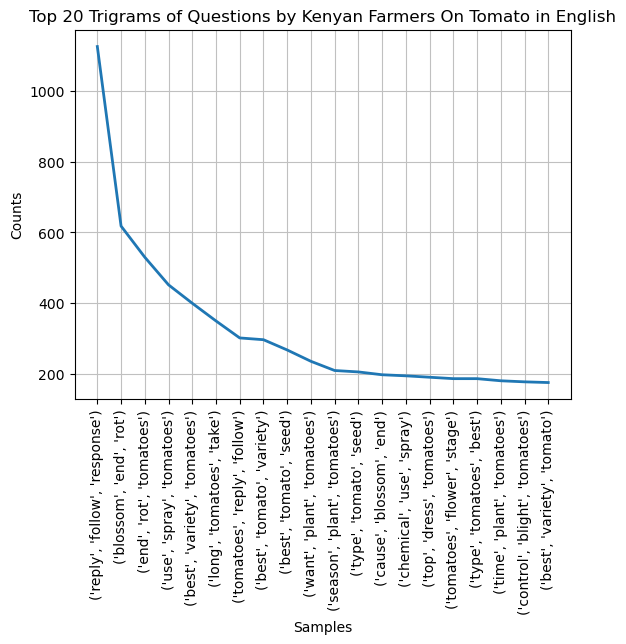

In [31]:
#plot frequency distribution of trigrams
fdist = FreqDist(all_trigrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} Trigrams of Questions by Kenyan Farmers On Tomato in English")
plt.savefig("top20trigrams_tomato_ken_eng.png")

In [37]:
#interactive directed network graph of top 30 trigrams...with help from Anaconda Assistant

# Input variables:
# - trigram_freq: Counter object with trigram frequencies (ranging from 100 to 650)
# - unigram_freq: Counter object with unigram frequencies (up to 38000)

#choose most frequent N bigrams, after dropping 1st trigram:
top_n = 40
top_trigrams = trigram_freq.most_common()[1:top_n+2]
del top_trigrams[5]

# Create a directed graph
G = nx.DiGraph()

# For trigrams, we'll create a path: word1 -> word2 -> word3
for trigram, frequency in top_trigrams:
    word1, word2, word3 = trigram
    
    # Add edges with weights based on frequency
    G.add_edge(word1, word2, value=frequency, title=f"Part of trigram: {' '.join(trigram)}, Frequency: {frequency}")
    G.add_edge(word2, word3, value=frequency, title=f"Part of trigram: {' '.join(trigram)}, Frequency: {frequency}")

# Calculate node sizes based on unigram frequencies
max_node_size = 50  # Maximum node size for visualization
min_node_size = 10  # Minimum node size for visualization

# Get all unique words from the trigrams
all_words = set()
for trigram, _ in top_trigrams:
    all_words.update(trigram)

# Set node sizes based on unigram frequencies
for word in all_words:
    # Get frequency from unigram counter, default to minimum if not found
    frequency = unigram_freq.get(word, 500)
    
    # Scale node size based on frequency
    # Map from range [5000, 15000] to [min_node_size, max_node_size]
    size = min_node_size + (max_node_size - min_node_size) * (
        (frequency - 500) / (38000 - 500)
    ) if frequency >= 10000 else min_node_size

    
    # Set node attributes
    G.nodes[word]['size'] = size
    G.nodes[word]['title'] = f"{word}: {frequency}"
    G.nodes[word]['label'] = word

# Create interactive network with directed edges
net = Network(notebook=True, height="750px", width="100%", bgcolor="#ffffff", font_color="#333333", directed=True)
net.heading = ""

net.from_nx(G)

# Configure physics for better visualization
net.toggle_physics(True)
net.barnes_hut(gravity=-2000, central_gravity=0.3, spring_length=150)

# Subtle color palette
subtle_colors = [
    '#E6E6FA', '#D8BFD8', '#DDA0DD', '#EE82EE', '#DA70D6',
    '#BA55D3', '#9370DB', '#8A2BE2', '#9400D3', '#9932CC',
    '#8B008B', '#800080', '#4B0082', '#6A5ACD', '#483D8B',
    '#7B68EE', '#0000FF', '#0000CD', '#00008B', '#000080'
]

# Add edge thickness based on trigram frequency and make arrows somewhat opaque
for edge in net.edges:
    freq = edge['value']
    # Map from range [100, 650] to [1, 8] for edge width
    edge['width'] = 1 + 7 * ((freq - 100) / (650 - 100)) if freq >= 100 else 1
    edge['title'] = f"Frequency: {freq}"
    
    # Somewhat opaque curved arrows
    edge['color'] = {'color': '#848484', 'opacity': 0.5}  # 50% opacity
    edge['arrows'] = {'to': {'enabled': True, 'scaleFactor': 0.6}}
    edge['smooth'] = {'type': 'curvedCW', 'roundness': 0.2}

# Enhance node appearance with bold labels and subtle colors
for i, node in enumerate(net.nodes):
    node['font'] = {'bold': True, 'size': 16, 'face': 'arial'}
    node['color'] = subtle_colors[i % len(subtle_colors)]
    node['borderWidth'] = 2
    node['borderWidthSelected'] = 4

# Save the HTML file with the title and legend included
filename = "40trigram_eng_ken_tomato_network.html"
net.write_html(filename) 
print(f"Visualization saved as '{filename}'")

# Inject title + subtitle inside the iframe display
with open(filename, "r", encoding="utf-8") as f:
    html = f.read()

    header_html = f"""
    <div style="text-align:center; font-family:Arial; padding-top:10px;">
        <h1 style="margin-bottom:2px; font-size:20px;">Network Graph: Top 40 Trigrams from Kenyan Farmers Questions on Tomato in English</h1>
        <h3 style="margin-top:0; color:#555; font-size:14px;">Word circle size = word frequency, arrow width = trigram frequency, Source: WeFarm 2022 SMS Platform</h3>
        <hr style="width:80%; margin-top:10px; margin-bottom:15px;">
    </div>
    """

# Insert heading right after <body>
html = html.replace("<body>", "<body>" + header_html)

with open(filename, "w", encoding="utf-8") as f:
    f.write(html)

#display in notebook:
display(IFrame(filename, width="100%", height="800px"))


Visualization saved as '40trigram_eng_ken_tomato_network.html'


### Save top 500 bigrams, trigrams to CSV files; plot top 40 quadgrams 

In [20]:
#find top 500 bigrams:
top_500 = bigram_freq.most_common(500)
#convert top_500 list to df, and join bigrams with '_' as separators for later translation, note: there are no duplicates
ken_bigrams_500_df = pd.DataFrame(top_500, columns=['bigram','count'])
ken_bigrams_500_df["bigram_str"] = ken_bigrams_500_df["bigram"].apply(lambda t: "_".join(t))
ken_bigrams_500_df.head()

,bigram,count,bigram_str
0,"(plant, tomatoes)",3636,plant_tomatoes
1,"(type, tomatoes)",1504,type_tomatoes
2,"(spray, tomatoes)",1402,spray_tomatoes
3,"(tomato, seed)",1335,tomato_seed
4,"(variety, tomatoes)",1324,variety_tomatoes


In [21]:
#save in csv file:
ken_bigrams_500_df.to_csv('ken_eng_bigrams_tomato_top500.csv')


In [22]:
#find top 500 trigrams:
top_500 = trigram_freq.most_common(500)
#convert top_500 list to df, and join trigrams with '_' as separators for later translation, note: there are no duplicates
ken_trigrams_500_df = pd.DataFrame(top_500, columns=['trigram','count'])
ken_trigrams_500_df["trigram_str"] = ken_trigrams_500_df["trigram"].apply(lambda t: "_".join(t))
ken_trigrams_500_df.head()

,trigram,count,trigram_str
0,"(reply, follow, response)",1125,reply_follow_response
1,"(blossom, end, rot)",618,blossom_end_rot
2,"(end, rot, tomatoes)",530,end_rot_tomatoes
3,"(use, spray, tomatoes)",452,use_spray_tomatoes
4,"(best, variety, tomatoes)",400,best_variety_tomatoes


In [23]:
#save in csv file:
ken_trigrams_500_df.to_csv('ken_eng_trigrams_tomato_top500.csv')


In [24]:
#create list of quadgrams, after checking # tokens >= 4
#from nltk.util import ngrams

all_quadgrams = []

for question in ken_eng_tokens:
    if len(question) < 4:
        continue
            #create bigrams iterator for each element of tokens: 
    else:
        all_quadgrams.extend(list(ngrams(question,4)))
        


In [25]:
print("# of quadgrams: ", len(all_quadgrams))


# of quadgrams:  177850


In [26]:
quadgram_freq = Counter(all_quadgrams)

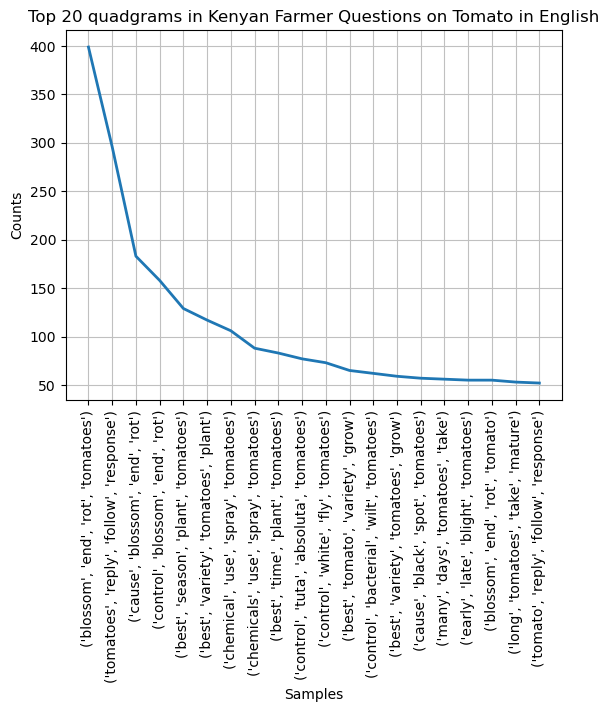

In [27]:
#top 20 quadgram plot

fdist = FreqDist(all_quadgrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} quadgrams in Kenyan Farmer Questions on Tomato in English")
plt.savefig("top20quadgrams_ken_tomato_eng.png")

In [28]:
#find top 500 quadgrams:
top_500 = quadgram_freq.most_common(500)
#convert top_500 list to df, and join quadgrams with '_' as separators for later translation, note: there are no duplicates
ken_quadgrams_500_df = pd.DataFrame(top_500, columns=['quadgram','count'])
ken_quadgrams_500_df["quadgram_str"] = ken_quadgrams_500_df["quadgram"].apply(lambda t: "_".join(t))

In [29]:
#save in csv file:
ken_quadgrams_500_df.to_csv('ken_eng_quadgrams_tomato_top500.csv')